## Advanced Lane Finding Project

The goals / steps of this project are the following:
1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
2. Apply a distortion correction to raw images.
3. Use color transform, gradients, etc., to create a thresholded binary image.
4. Apply a perspective transform to rectify binary image ("birds-eye view").
5. Detect lane pixels and fit to find the lane boundary.
6. Determine the curvature of the lane and vehicle position with respect to center.
7. Warp the detected lane boundaries back onto the original image.
8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

In [2]:
# Import Line class
from utils import Line
# Create Line instance
line = Line()
# Output image location
OUTPUT_LOCATION = 'output_images/'

### Camera Calibration

Camera calibration function is in **`Line`** class, in the **`cal_undistort`** and **`calibrate_camera`** routines. 
**`cal_undistort`** routine takes raw image or video frame and output undistorted images
**`calibrate_camera`** routine is only executed once after class instance being created and first image being passed through to the instance. This routine will process chessboard images and dump calibration data into a pickle file.

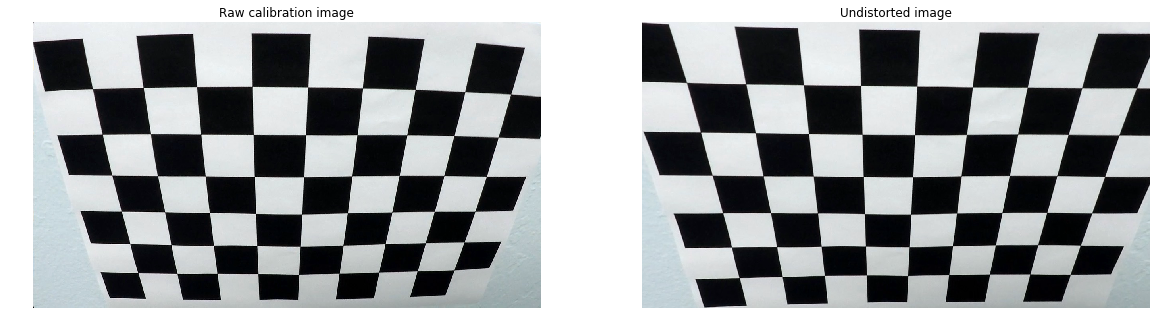

In [3]:
# Calibrate camera
# Import random raw image from camera calibration
raw = cv2.imread('camera_cal/calibration2.jpg')
undistorted = line.cal_undistort(raw)
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(raw)
plt.axis('off')
plt.title('Raw calibration image')
# Plot undistorted image
plt.subplot(1,2,2)
plt.imshow(undistorted)
plt.axis('off')
plt.title('Undistorted image')
plt.savefig(OUTPUT_LOCATION + 'fig1.png')
plt.show()

Now the camera has been calibrated.

The following images show the raw road image and its associate processed image with distortion correction.

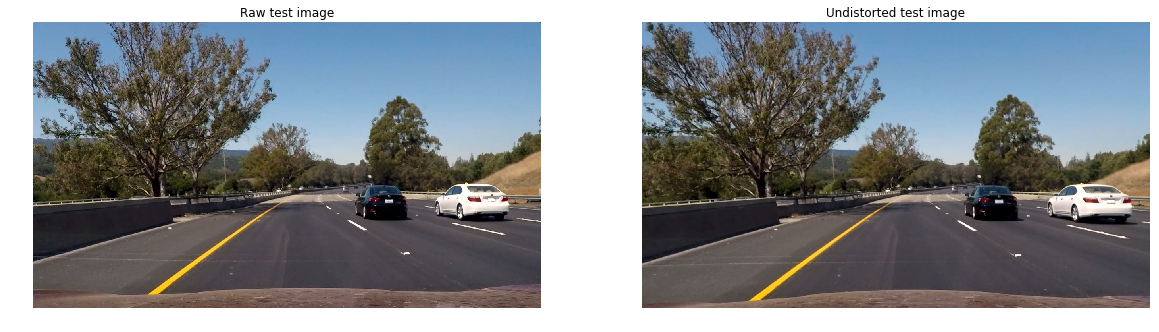

In [4]:
# Apply undistortion correction to test image
# Import and plot raw test image
raw = 'test_images/test6.jpg'
raw = cv2.imread(raw)
raw = cv2.cvtColor(raw, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(raw)
plt.axis('off')
plt.title('Raw test image')
# Plot undistorted test image
undistorted = line.cal_undistort(raw)
plt.subplot(1,2,2)
plt.imshow(undistorted)
plt.axis('off')
plt.title('Undistorted test image')
plt.savefig(OUTPUT_LOCATION + 'fig2.png')
plt.show()

### Applying Color and Gradient Thresholding, and Extracting Lane Pixels

The following steps are needed to identify the lane lines:

1. Gradient thresholding using Sobel operation in X direction. 
2. Color thresholding in Saturation of image in HLS color space

Routine **`color_gradient`** will take warped or undistorted images, apply color and X-direction gradient thresholding functions, and binarize.

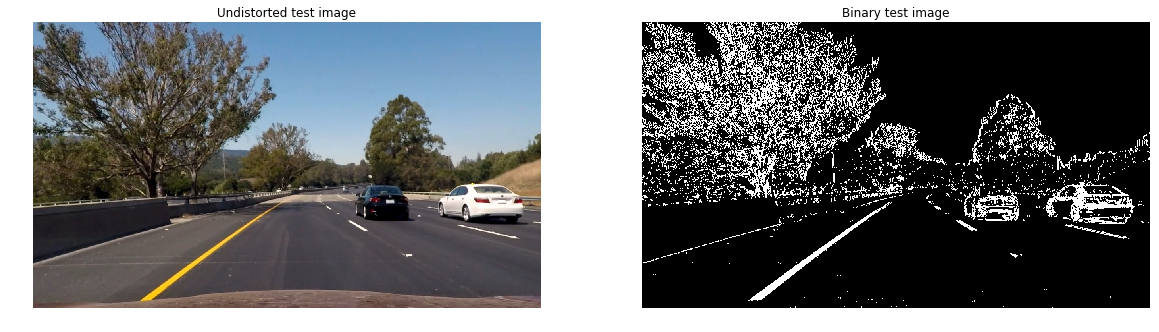

In [5]:
# Apply color and gradient combined thresholding and create binary image
# Plot undistorted test image
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(undistorted)
plt.axis('off')
plt.title('Undistorted test image')
# Plot binary test image
binary = line.color_gradient(undistorted)
plt.subplot(1,2,2)
plt.imshow(binary)
plt.axis('off')
plt.title('Binary test image')
plt.savefig(OUTPUT_LOCATION + 'fig3.png')
plt.show()

### Performing the Perspective Transformation

The perspective transformation takes given points on image to map them to a warped image with a new perspective. A bird's-eye view transform allows images to be seen from above from a projected point of view, which is useful for lane curvature calculation.

The warped function is encapculated in **`perspective_transform`** member function of class **`Lane`**. In order to perform the transformation, two sets of four-point source and destination points are provided, the following chart shows the chosen src and dst points:

|Source Points     | (255,695)   (585,455)   (700,455)   (1060,690)|
|------------------------------------------------------------------|
|Destination Points| (305,695)   (305,0)     (1010,0)    (1010,690)|

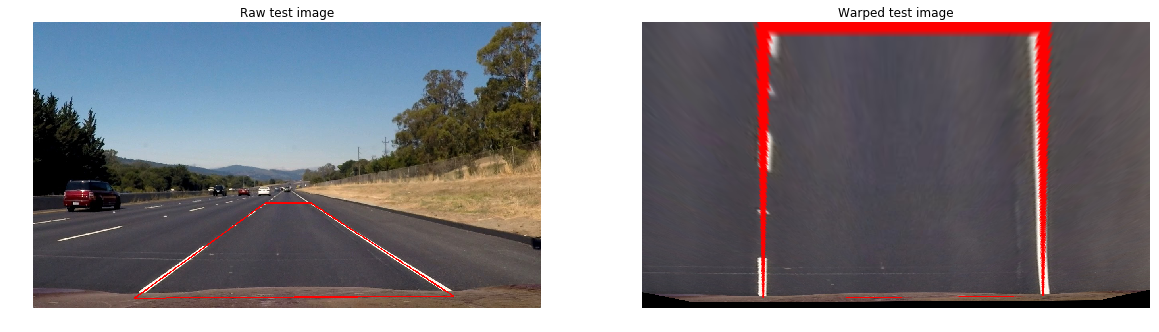

In [6]:
# Apply Perspective Transform function
raw = cv2.imread('test_images/straight_lines2.jpg')
raw = cv2.cvtColor(raw, cv2.COLOR_RGB2BGR)
# Source image points
src = np.float32([[255, 695], [585, 455], [700, 455], [1060, 690]])
# Destination image points
dst = np.float32([[305, 695], [305, 0], [1010, 0], [1010, 690]])
# Draw lines on raw image
cv2.line(raw, (255,695),(585,455), color=[255,0,0], thickness=2)
cv2.line(raw, (585,455),(700,455), color=[255,0,0], thickness=2)
cv2.line(raw, (700,455),(1060,690), color=[255,0,0], thickness=2)
cv2.line(raw, (1060,690),(255,695), color=[255,0,0], thickness=2)
# Perform perspective transform
warped = line.perspective_transform(raw, direction='forward')
# Plot raw test image
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(raw)
plt.axis('off')
plt.title('Raw test image')
# Plot warped test image
plt.subplot(1,2,2)
plt.imshow(warped)
plt.axis('off')
plt.title('Warped test image')
plt.savefig(OUTPUT_LOCATION + 'fig4.png')
plt.show()

The following shows the combination of perspective transform and binarize

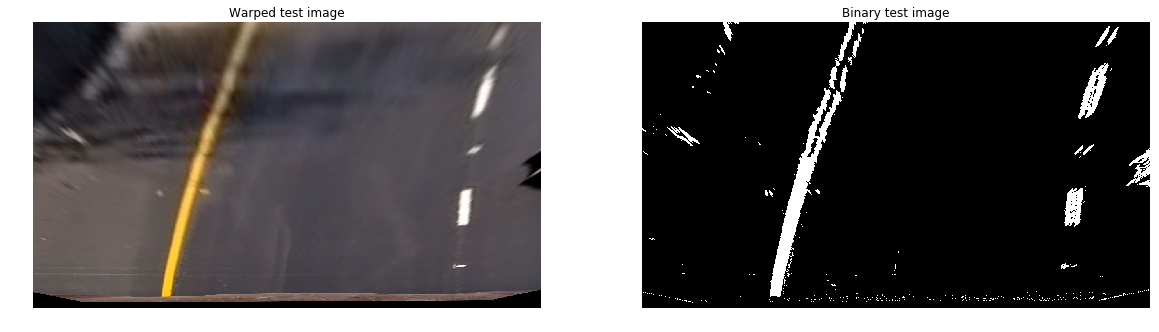

In [7]:
raw = cv2.imread('test_images/test6.jpg')
raw = cv2.cvtColor(raw, cv2.COLOR_RGB2BGR)
# Apply perspective transform to bird's-eye view
warped = line.perspective_transform(raw, direction='forward')
# Apply color and gradient combined thresholding, and binarize
binary = line.color_gradient(warped)
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(warped)
plt.axis('off')
plt.title('Warped test image')
# Plot binary test
plt.subplot(1,2,2)
plt.imshow(binary)
plt.axis('off')
plt.title('Binary test image')
plt.savefig(OUTPUT_LOCATION + 'fig5.png')
plt.show()

### Calculating Lane Curvature

After the actions of **`Camera calibration`**, **`Distortion correction`**, **`Color/gradient thresholding`**, and **`Perspective transform`**, we will begin detecting the actual lane lines and calculating its curvature.

In order to calculate the road line curvature, there are two line detection methods are used (code courtesy is to Udacity)

1. **`basic_lane_find`**. Uses sliding window to identify lane lines and performs a second order polynomial fit to calculate road curvature.
2. **`lane_find`**. Smartly calculating road curvature with respect to the outputs of **`basic_lane_find`** function.

<function matplotlib.pyplot.show>

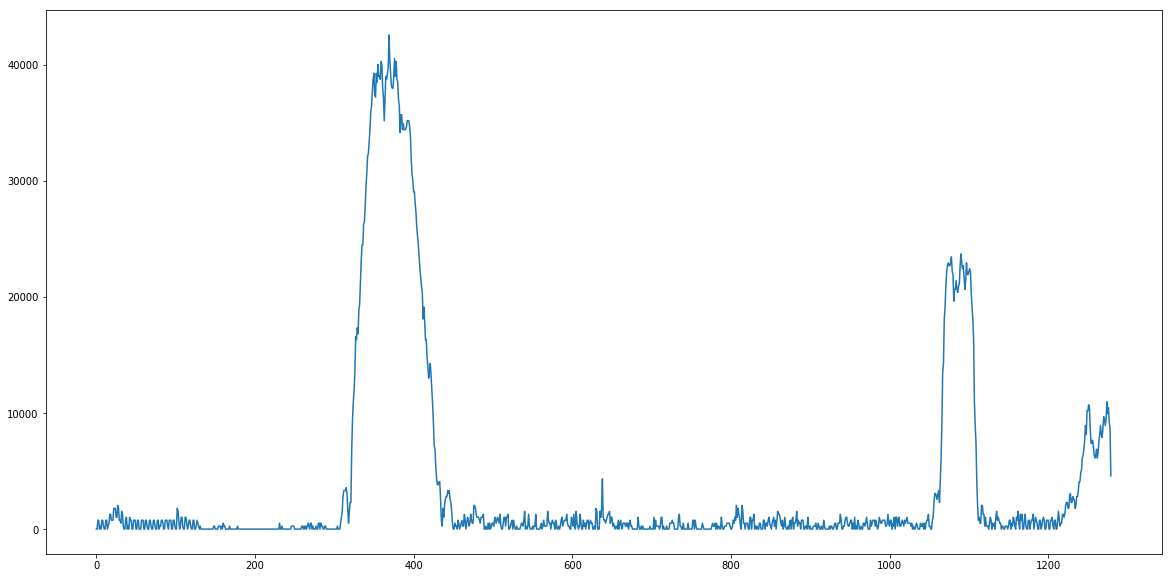

In [8]:
# Histogram plot
histogram = np.sum(binary[binary.shape[0] // 2:, :, 0], axis=0)
plt.figure(figsize=(20,10))
plt.plot(histogram)
plt.savefig(OUTPUT_LOCATION + 'fig6.png')
plt.show

Following code will be performing the road curvature calculation. The overall steps are:

1. Sliding the rectangle windows on the warped binary image.
2. Appending the indexes of pixels that are identified inside of the window.
3. Updating leftx_current and rightx_current array.
4. Calculating the X and Y coordinates based on the identified pixels from both left and right lines.
5. Performing second order polynomial fit over calculated X and Y coordiantes.
6. Calculating fitted X coordinates for both lines based on a new generated Y coordinates and fitted polynomial coefficients.

<function matplotlib.pyplot.show>

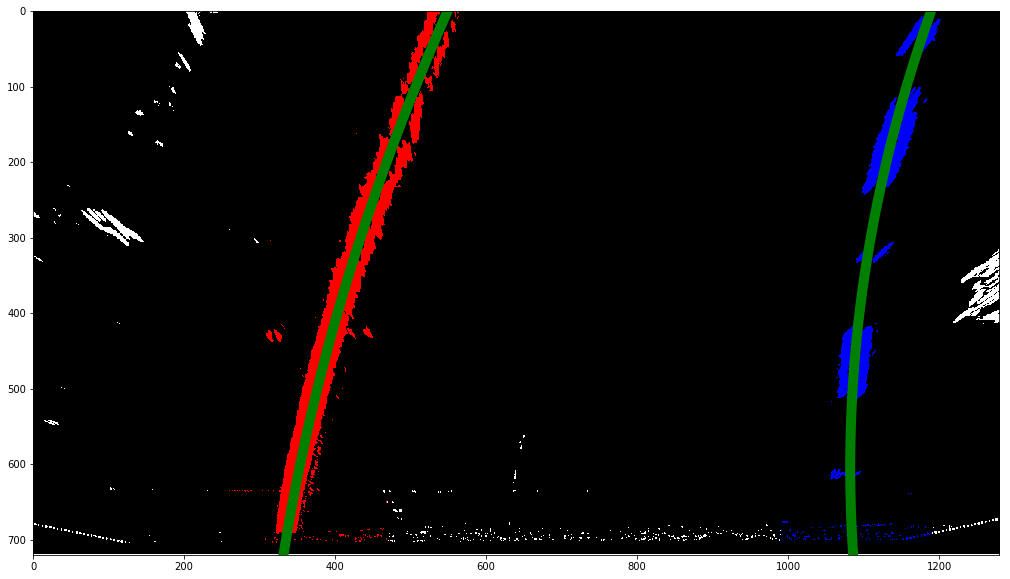

In [9]:
binary_warped = binary
# Find the peak of the left and right halves of the histogram
midpoint = np.int(histogram.shape[0] / 2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint
# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0] / nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set the minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []
# Step through the windows one by one
for window in range(nwindows):
	# Identify window boundaries in x and y (and right and left)
	win_y_low = binary_warped.shape[0] - (window + 1) * window_height
	win_y_high = binary_warped.shape[0] - window * window_height
	win_xleft_low = leftx_current - margin
	win_xleft_high = leftx_current + margin
	win_xright_low = rightx_current - margin
	win_xright_high = rightx_current + margin
	# Identify the nonzero pixels in x and y within the window
	good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (
		nonzerox < win_xleft_high)).nonzero()[0]
	good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (
		nonzerox < win_xright_high)).nonzero()[0]
	# Append these indices to the lists
	left_lane_inds.append(good_left_inds)
	right_lane_inds.append(good_right_inds)
	# If you found > minpix pixels, recenter next window on their mean position
	if len(good_left_inds) > minpix:
		leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
	if len(good_right_inds) > minpix:
		rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)
# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds]
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
#Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0] - 1, binary_warped.shape[0])
left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]

binary_warped[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
binary_warped[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

plt.figure(figsize=(20,10))
plt.imshow(binary_warped)
left, right = plt.plot(left_fitx, ploty, right_fitx, ploty)
plt.setp(left, linewidth=10, color='g')
plt.setp(right, linewidth=10, color='g')
#plt.plot(right_fitx, ploty, color='green')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.savefig(OUTPUT_LOCATION + 'fig7.png')
plt.show